# Perform Experiments with DeepFace on LFW dataset

In [1]:
# built-in dependencies
import os

# 3rd party dependencies
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_lfw_pairs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from deepface import DeepFace
from deepface.modules import preprocessing
import lightgbm as lgb
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import shap

2024-07-30 15:44:40.593132: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 15:44:40.670688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-30 15:44:40.670710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/sefik/.local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
seed = 17
detector_backend = "retinaface"
k = 10
multiclass = False # multiclass with 2 classes or binary. both are same.
enforce_training = False

In [3]:
print(f"This experiment is done with pip package of deepface with {DeepFace.__version__} version")

This experiment is done with pip package of deepface with 0.0.90 version


### Configuration Sets

In [4]:
# all configuration alternatives for 4 dimensions of arguments
alignment = [True]
models = ["Facenet", "Facenet512", "VGG-Face", "ArcFace", "Dlib"] # 99.1
detectors = ["retinaface"]
metrics = ["euclidean_l2"]
expand_percentage = 0 # TODO: find increase impact

### Create Required Folders if necessary

In [5]:
target_paths = [
    "lfwe",
    "lfwe/test",
    "lfwe/train",
    "lfwe/10_folds",
    "dataset",
    "outputs",
    "outputs/test",
    "outputs/train",
    "outputs/10_folds",
    "results",
    "models",
]
for target_path in target_paths:
    if os.path.exists(target_path) is not True:
        os.mkdir(target_path)
        print(f"{target_path} is just created")

### Load LFW Datasets

In [6]:
def retrieve_lfe(task: str):
    if task == "test":
        instances = 1000
    elif task == "train":
        instances = 2200
    elif task == "10_folds":
        instances = 6000
    else:
        raise ValueError(f"unimplemented task - {task}")

    pairs_touch = f"outputs/{task}_lfwe.txt"

    target_path = f"dataset/{task}_lfw.npy"
    labels_path = f"dataset/{task}_labels.npy"

    if os.path.exists(target_path) != True:
        fetched_lfw_pairs = fetch_lfw_pairs(
            subset = task,
            color = True,
            # memory allocation problem occurs for validation set
            resize = 2 if task != "10_folds" else 1,
            funneled = False,
            slice_=None,
        )
        print("fetched")
        pairs = fetched_lfw_pairs.pairs
        labels = fetched_lfw_pairs.target
        # target_names = fetched_lfw_pairs.target_names
        np.save(target_path, pairs)
        np.save(labels_path, labels)
    else:
        if os.path.exists(pairs_touch) != True:
            # loading pairs takes some time. but if we extract these pairs as image, no need to load it anymore
            pairs = np.load(target_path)
        labels = np.load(labels_path)
    
    # store to file system
    for i in tqdm(range(0, instances)):
        img1_target = f"lfwe/{task}/{i}_1.jpg"
        img2_target = f"lfwe/{task}/{i}_2.jpg"
        
        if os.path.exists(img1_target) != True:
            img1 = pairs[i][0]
            # plt.imsave(img1_target, img1/255) #works for my mac
            plt.imsave(img1_target, img1) #works for my debian
        
        if os.path.exists(img2_target) != True:
            img2 = pairs[i][1]
            # plt.imsave(img2_target, img2/255) #works for my mac
            plt.imsave(img2_target, img2) #works for my debian
        
    if os.path.exists(pairs_touch) != True:
        open(pairs_touch,'a').close()
    

In [7]:
retrieve_lfe(task = "test")
retrieve_lfe(task = "train")
retrieve_lfe(task = "10_folds")

100%|██████████| 6000/6000 [00:00<00:00, 138320.88it/s]


# Perform Experiments

In [8]:
def perform_experiments():    
    for model_name in models:
        for detector_backend in detectors:
            for distance_metric in metrics:
                for align in alignment:
                    
                    if detector_backend == "skip" and align is True:
                        # Alignment is not possible for a skipped detector configuration
                        continue
                    
                    calculate_distances(
                        model_name=model_name,
                        detector_backend=detector_backend,
                        distance_metric=distance_metric,
                        align=align,
                    )
                    
def calculate_distances(
        model_name: str,
        detector_backend: str,
        distance_metric: str = "euclidean_l2",
        align: bool = True
):
    for experiment in ["test", "train", "10_folds"]:
        if experiment == "test":
            instances = 1000
        elif experiment == "train":
            instances = 2200
        elif experiment == "10_folds":
            instances = 6000
        else:
            raise ValueError(f"unimplemented experiment - {experiment}")

        labels = np.load(f"dataset/{experiment}_labels.npy")

        alignment_text = "aligned" if align is True else "unaligned"
        task = f"{experiment}/{model_name}_{detector_backend}_{distance_metric}_{alignment_text}"
        output_file = f"outputs/{task}.csv"
        print(output_file)

        # check file is already available
        if os.path.exists(output_file) is True:
            continue
        
        distances = []
        for i in tqdm(range(0, instances), desc = task):
            img1_target = f"lfwe/{experiment}/{i}_1.jpg"
            img2_target = f"lfwe/{experiment}/{i}_2.jpg"
            result = DeepFace.verify(
                img1_path=img1_target,
                img2_path=img2_target,
                model_name=model_name,
                detector_backend=detector_backend,
                distance_metric=distance_metric,
                align=align,
                enforce_detection=False,
                expand_percentage=expand_percentage,
            )
            distance = result["distance"]
            distances.append(distance)
        # -----------------------------------
        df = pd.DataFrame(list(labels), columns = ["actuals"])
        df["distances"] = distances
        df.to_csv(output_file, index=False)

In [9]:
perform_experiments()

outputs/test/Facenet_retinaface_euclidean_l2_aligned.csv
outputs/train/Facenet_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/Facenet_retinaface_euclidean_l2_aligned.csv
outputs/test/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/train/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/test/VGG-Face_retinaface_euclidean_l2_aligned.csv
outputs/train/VGG-Face_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/VGG-Face_retinaface_euclidean_l2_aligned.csv
outputs/test/ArcFace_retinaface_euclidean_l2_aligned.csv
outputs/train/ArcFace_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/ArcFace_retinaface_euclidean_l2_aligned.csv
outputs/test/Dlib_retinaface_euclidean_l2_aligned.csv
outputs/train/Dlib_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/Dlib_retinaface_euclidean_l2_aligned.csv


# Data Frame

In [10]:
# pre-tuned thresholds for RetinaFace detector
thresholds = {
    "Facenet": 1.0771751259493634,
    "Facenet512": 1.080821730376328,
    "VGG-Face": 1.1952250102966764,
    "ArcFace": 1.1601818883318848,
    "Dlib": 0.4022031592966787,
    "GhostFaceNet": 1.2554638430323275,
    "SFace": 1.226662066811263,
}

In [11]:
tasks = ["train", "test", "10_folds"]

dfs = {}
for task in tasks:
    dfs[task] = None
    for model in models:
        df_path = f"outputs/{task}/{model}_{detector_backend}_euclidean_l2_aligned.csv"
        print(df_path)
        current_df = pd.read_csv(df_path).rename(columns = {"distances": model})

        if dfs[task] is None:
            dfs[task] = current_df.copy()
        else:
            current_df = current_df.drop(columns = ["actuals"])
            dfs[task] = pd.concat([dfs[task], current_df], axis=1)

outputs/train/Facenet_retinaface_euclidean_l2_aligned.csv
outputs/train/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/train/VGG-Face_retinaface_euclidean_l2_aligned.csv
outputs/train/ArcFace_retinaface_euclidean_l2_aligned.csv
outputs/train/Dlib_retinaface_euclidean_l2_aligned.csv
outputs/test/Facenet_retinaface_euclidean_l2_aligned.csv
outputs/test/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/test/VGG-Face_retinaface_euclidean_l2_aligned.csv
outputs/test/ArcFace_retinaface_euclidean_l2_aligned.csv
outputs/test/Dlib_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/Facenet_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/VGG-Face_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/ArcFace_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/Dlib_retinaface_euclidean_l2_aligned.csv


In [12]:
dfs["train"].head()

,actuals,Facenet,Facenet512,VGG-Face,ArcFace,Dlib
0,1,0.665361,0.529663,0.725590,0.754328,0.241096
1,1,0.761471,0.851045,0.926009,0.872847,0.361268
2,1,0.929644,1.010149,0.957905,1.005725,0.320210
3,1,0.298545,0.489141,0.789548,0.649016,0.259671
4,1,0.613064,0.679703,0.991215,0.950595,0.356630


In [13]:
def add_classification_results(df: pd.DataFrame) -> pd.DataFrame:
    for model_name in models:
        idx = df[df[model_name] < thresholds[model_name]].index
        # df[f"{model_name}_clf"] = -1 # got 99.1 with this but multiplication is not meaningful!
        df[f"{model_name}_clf"] = 0 # this also gives 99.1 score
        df.loc[idx, f"{model_name}_clf"] = 1
    return df

dfs["train"] = add_classification_results(dfs["train"])
dfs["10_folds"] = add_classification_results(dfs["10_folds"])
dfs["test"] = add_classification_results(dfs["test"])

In [14]:
def add_classification_sum(df: pd.DataFrame) -> pd.DataFrame:
    df["clf_sum"] = 0
    for model_name in models:
        df["clf_sum"] += df[f"{model_name}_clf"]
    return df

dfs["train"] = add_classification_sum(dfs["train"])
dfs["10_folds"] = add_classification_sum(dfs["10_folds"])
dfs["test"] = add_classification_sum(dfs["test"])

In [15]:
def add_classification_multiplications(df: pd.DataFrame) -> pd.DataFrame:
    df["clf_multiplication"] = 1
    for model_name in models:
        df["clf_multiplication"] *= np.power(2, df[f"{model_name}_clf"])
    return df

dfs["train"] = add_classification_multiplications(dfs["train"])
dfs["10_folds"] = add_classification_multiplications(dfs["10_folds"])
dfs["test"] = add_classification_multiplications(dfs["test"])

In [16]:
def add_distance_additions(df: pd.DataFrame) -> pd.DataFrame:
    df["distance_sums"] = 0
    for model_name in models:
        df["distance_sums"] += df[f"{model_name}"]
    return df

dfs["train"] = add_distance_additions(dfs["train"])
dfs["10_folds"] = add_distance_additions(dfs["10_folds"])
dfs["test"] = add_distance_additions(dfs["test"])

In [17]:
def add_distance_multiplications(df: pd.DataFrame) -> pd.DataFrame:
    df["distance_multiplications"] = 1
    for model_name in models:
        df["distance_multiplications"] *= df[f"{model_name}"]
    return df

dfs["train"] = add_distance_multiplications(dfs["train"])
dfs["10_folds"] = add_distance_multiplications(dfs["10_folds"])
dfs["test"] = add_distance_multiplications(dfs["test"])

In [18]:
dfs["train"].shape[1] - 1

14

In [19]:
dfs["train"].sample(5)

,actuals,Facenet,Facenet512,VGG-Face,ArcFace,Dlib,Facenet_clf,Facenet512_clf,VGG-Face_clf,ArcFace_clf,Dlib_clf,clf_sum,clf_multiplication,distance_sums,distance_multiplications
1640,0,1.386192,1.204335,1.349961,1.358104,0.521829,0,0,0,0,0,0,1,5.820420,1.597177
1460,0,1.382767,1.405690,1.372089,1.410504,0.513630,0,0,0,0,0,0,1,6.084680,1.932172
469,1,0.533456,0.464634,0.814241,0.755015,0.298058,1,1,1,1,1,5,32,2.865404,0.045417
1600,0,1.491545,1.494115,1.376989,1.344520,0.523635,0,0,0,0,0,0,1,6.230803,2.160462
2169,0,1.514211,1.360036,1.315516,1.426861,0.577663,0,0,0,0,0,0,1,6.194287,2.233002


In [20]:
dfs["train"].shape

(2200, 15)

In [21]:
categorical_features = [column for column in dfs["train"].columns if column.endswith("_clf")]

# LightGBM

In [22]:
feature_names = list(dfs["train"].drop(columns=["actuals"]).columns)

y_train = dfs["train"]["actuals"].values
x_train = dfs["train"].drop(columns=["actuals"]).values

y_test = dfs["test"]["actuals"].values
x_test = dfs["test"].drop(columns=["actuals"]).values

y_val = dfs["10_folds"]["actuals"].values
x_val = dfs["10_folds"].drop(columns=["actuals"]).values

lgb_train = lgb.Dataset(
    x_train, y_train, 
    feature_name = feature_names,
    categorical_feature = categorical_features, free_raw_data=False
)

lgb_test = lgb.Dataset(
    x_test, y_test,
    feature_name = feature_names,
    categorical_feature = categorical_features, free_raw_data=False
)

In [23]:
if multiclass is True:
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 2, #same person, different persons
        'metric': 'multi_logloss',
        'num_leaves': pow(2, 5) - 1,
        'learning_rate': 0.01,
        'verbose': -1,
        'max_depth': 5,
    }
else: # binary
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': pow(2, 5) - 1,
        'learning_rate': 0.01,
        'verbose': -1,
        'max_depth': 5,
    }

In [24]:
gbms = []
learning_curves = []
best_iterations = []
feature_importances = []

for k in range(0, k):
    model_file = f"models/boosted_lightface_{k}.txt"
    if enforce_training is False and os.path.exists(model_file) is True:
        print(f"Using pre-trained model for {k+1}-th fold.")
        gbm = lgb.Booster(model_file=model_file)
        gbms.append(gbm)
        continue
    
    print(f"Training {k}-th model")

    valid_from = k * 600
    valid_until = valid_from + 600

    lgb_val = lgb.Dataset(
        x_val[valid_from:valid_until],
        y_val[valid_from:valid_until],
        feature_name = feature_names,
        categorical_feature = categorical_features, free_raw_data=False
    )

    # copy the rest of validation set into training
    # train_indices = list(range(0, valid_from)) + list(range(valid_until, len(x_val)))
    # x_train_extended = np.concatenate((x_train, x_val[train_indices]), axis=0)
    # y_train_extended = np.concatenate((y_train, y_val[train_indices]), axis=0)
    # lgb_train = lgb.Dataset(
    #     x_train_extended,
    #     y_train_extended,
    #     feature_name=feature_names,
    #     categorical_feature=categorical_features,
    #     free_raw_data=False
    # )

    evals_result = {}
    gbm = lgb.train(
        params = params,
        train_set = lgb_train,
        valid_sets = [lgb_train, lgb_val],
        num_boost_round=10000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=500),
            lgb.record_evaluation(evals_result),
        ],
    )

    gbm.save_model(f'models/boosted_lightface_{k}.txt')

    gbms.append(gbm)
    learning_curves.append(evals_result)
    best_iterations.append(gbm.best_iteration)
    feature_importances.append(gbm.feature_importance)

Using pre-trained model for 1-th fold.
Using pre-trained model for 2-th fold.
Using pre-trained model for 3-th fold.
Using pre-trained model for 4-th fold.
Using pre-trained model for 5-th fold.
Using pre-trained model for 6-th fold.
Using pre-trained model for 7-th fold.
Using pre-trained model for 8-th fold.
Using pre-trained model for 9-th fold.
Using pre-trained model for 10-th fold.


In [25]:
def find_accuracy(x, y, label):
    accuracies = []
    aucs = []
    fprs = []
    tprs = []
    for idx, gbm in enumerate(gbms):
        if label == "validation":
            x_org  = x.copy()
            y_org = y.copy()

            valid_from = k * 600
            valid_until = valid_from + 600

            x = x[valid_from:valid_until]
            y = y[valid_from:valid_until]

        if multiclass is True:
            predictions = gbm.predict(x)
            df = pd.DataFrame(predictions, columns = ["different_persons", "same_person"])
            pred_probas = df["same_person"].values.tolist()
        else:
            pred_probas = gbm.predict(x)

        fpr, tpr, _ = sklearn.metrics.roc_curve(y, pred_probas)
        auc = sklearn.metrics.roc_auc_score(y, pred_probas)
        auc = round(auc, 4)

        aucs.append(auc)
        fprs.append(fpr)
        tprs.append(tpr)

        classified_ones = 0
        if multiclass is True:
            for i, prediction_proba in enumerate(predictions):
                actual = y[i]
                
                prediction = np.argmax(prediction_proba)
                
                if actual == prediction:
                    classified_ones += 1
            accuracy = 100 * classified_ones / len(predictions)
        else:
            for i, prediction_proba in enumerate(pred_probas):
                actual = y[i]
                prediction = 1 if prediction_proba > 0.5 else 0
                if actual == prediction:
                    classified_ones += 1
            accuracy = 100 * classified_ones / len(pred_probas)
        
        accuracies.append(round(accuracy, 2))

        # restore
        if label == "validation":
            x = x_org.copy()
            y = y_org.copy()

    return (accuracies, aucs, fprs, tprs)

In [26]:
train_score, _, _, _ = find_accuracy(x_train, y_train, label = "train")
val_score, _, _, _ = find_accuracy(x_val, y_val, label = "validation")
test_score, test_aucs, test_fprs, test_tprs = find_accuracy(x_test, y_test, label = "test")

# winner_id = np.argmax(test_score) # cheating!
winner_id = np.argmax(val_score)

print(f"overperforming model on validation set is {winner_id}-th one")

# print(f"best score: {max(test_score)}") # cheating!
print(f"best score: {test_score[winner_id]}")

pd.DataFrame({"train": train_score, "validation": val_score, "test": test_score}).reset_index().rename(columns={"index": "fold"})

overperforming model on validation set is 6-th one
best score: 99.1


,fold,train,validation,test
0,0,99.64,98.00,99.0
1,1,99.45,98.33,99.1
2,2,99.41,98.17,99.0
3,3,99.45,98.33,99.1
4,4,99.45,98.33,99.1
5,5,99.91,98.00,98.7
6,6,99.45,98.50,99.1
7,7,99.45,98.33,99.1
8,8,99.45,98.33,99.1
9,9,99.45,98.50,99.1


# Loss functions

In [27]:
if learning_curves:

    for i in range(0, k+1):

        if multiclass is True:
            training_loss = learning_curves[i]["training"]["multi_logloss"]
            validation_loss = learning_curves[i]["valid_1"]["multi_logloss"]
        else:
            training_loss = learning_curves[i]["training"]["binary_logloss"]
            validation_loss = learning_curves[i]["valid_1"]["binary_logloss"]

        # fold_idx = winner_id
        # fold_idx = 9
        fold_idx = i
        best_iter = best_iterations[fold_idx]

        plt.plot(training_loss[:best_iter], label='Training loss')
        plt.plot(validation_loss[:best_iter], label='Validation loss')
        plt.xlabel('Iterations')
        plt.ylabel('Binary Logloss')
        plt.title(f'Training and Validation Loss in fold {fold_idx+1}')
        plt.legend()
        plt.show()

# Feature Importance

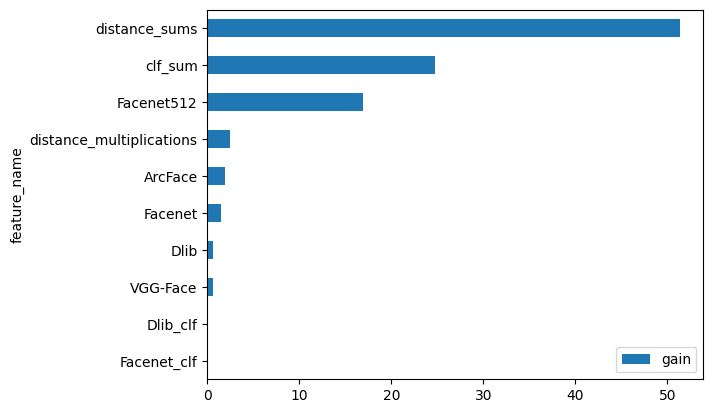

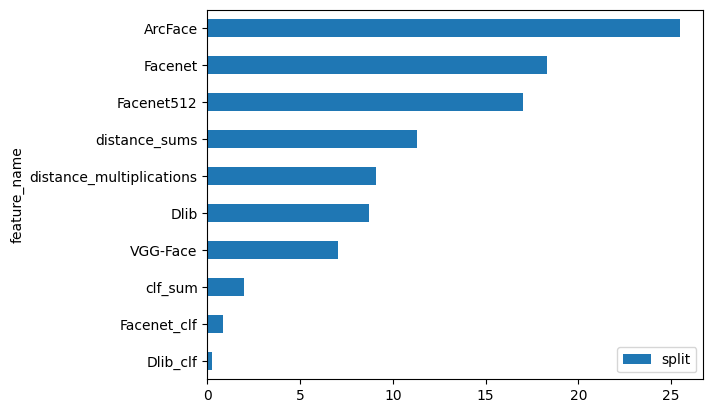

In [29]:
for importance_type in ["gain", "split"]:
    # feature importance with percentages
    fi_df = pd.DataFrame({
        "feature_name": gbms[winner_id].feature_name(),
        importance_type: gbms[winner_id].feature_importance(
            importance_type=importance_type
        )
    })

    fi_df = fi_df.sort_values(by = [importance_type], ascending=False)
    fi_df[importance_type] = 100 * fi_df[importance_type] / fi_df[importance_type].sum()
    fi_df = fi_df[fi_df[importance_type] > 0]

    ax = fi_df.plot.barh(x='feature_name', y=importance_type)
    ax.invert_yaxis()
    plt.legend(loc='lower right')
    # _ = ax.bar_label(ax.containers[0])
    plt.show()

In [36]:
# feature importance as table
feature_importances = {}
for importance_type in ["gain", "split"]:
    # feature importance with percentages
    fi_df = pd.DataFrame({
        "feature_name": gbms[winner_id].feature_name(),
        importance_type: gbms[winner_id].feature_importance(
            importance_type=importance_type
        )
    })

    fi_df = fi_df.sort_values(by = [importance_type], ascending=False)
    fi_df[importance_type] = round(100 * fi_df[importance_type] / fi_df[importance_type].sum(), 2)
    # fi_df = fi_df[fi_df[importance_type] > 0]

    feature_importances[importance_type] = fi_df

In [37]:
feature_importances["gain"].merge(feature_importances["split"], on = ["feature_name"], how = "left")

,feature_name,gain,split
0,distance_sums,51.37,11.30
1,clf_sum,24.72,1.97
2,Facenet512,16.87,17.03
3,distance_multiplications,2.49,9.08
4,ArcFace,1.89,25.46
5,Facenet,1.43,18.32
6,Dlib,0.60,8.71
7,VGG-Face,0.59,7.04
8,Dlib_clf,0.03,0.24
9,Facenet_clf,0.01,0.86


In [38]:
explainer = shap.Explainer(gbms[winner_id])
shap_values = explainer(x_test)

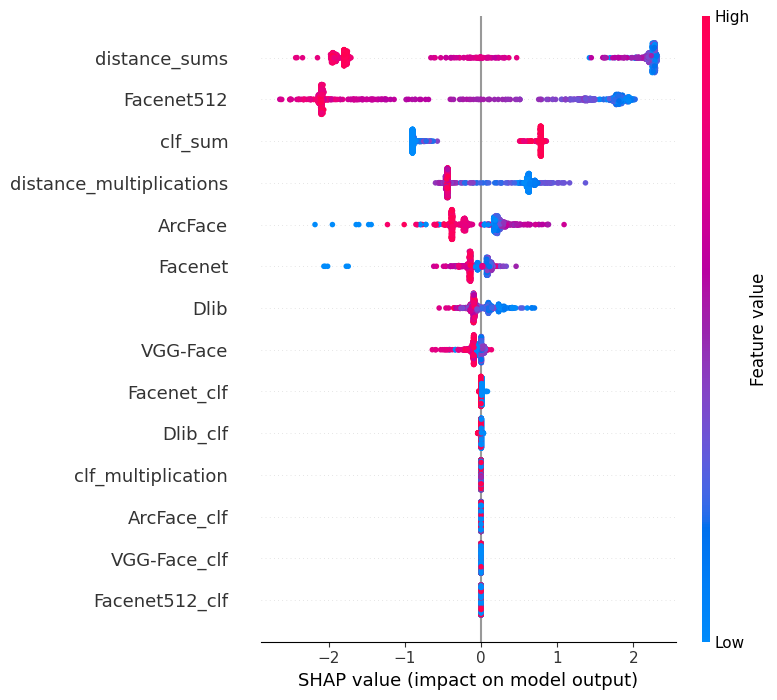

In [39]:
shap.summary_plot(shap_values, x_test, feature_names=feature_names)

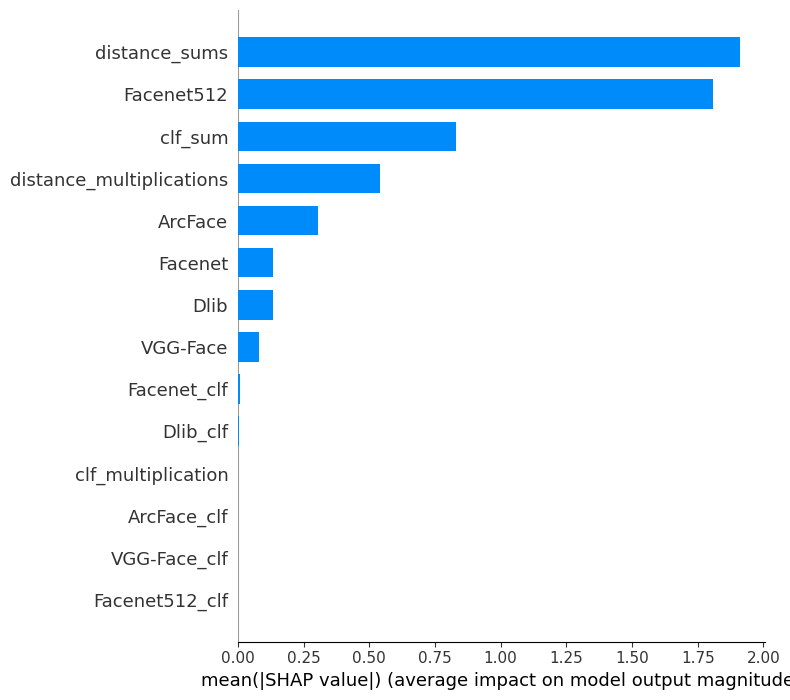

In [40]:
shap.summary_plot(shap_values, x_test, plot_type='bar', feature_names=feature_names)

### Confusion Matrix

In [41]:
pred_probas = gbms[winner_id].predict(x_test)
pred_classes = []
for pred_proba in pred_probas:
    if multiclass is True:
        pred_class = 1 if pred_proba[1] > pred_proba[0] else 0
    else:
        pred_class = 1 if pred_proba > 0.5 else 0
    pred_classes.append(pred_class)

cm = confusion_matrix(y_test, pred_classes)
print(cm)

[[498   2]
 [  7 493]]


In [42]:
accuracy= 100 * round(accuracy_score(y_test, pred_classes), 4)
precision = 100 * round(precision_score(y_test, pred_classes), 4)
recall = 100 * round(recall_score(y_test, pred_classes), 4)
f1 = 100 * round(f1_score(y_test, pred_classes), 4)

print(f"Boosted LightFace's {accuracy=}, {precision=}, {recall=}, {f1=}")

Boosted LightFace's accuracy=99.1, precision=99.6, recall=98.6, f1=99.1


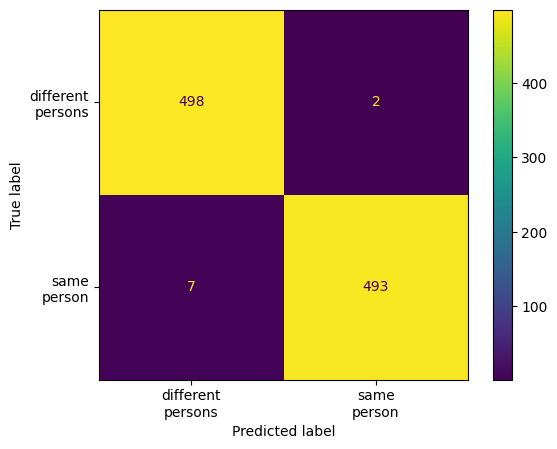

In [43]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["different\npersons", "same\nperson"]
)
disp.plot()
plt.show()

# ROC Curves

In [44]:
def plot_roc(model_name, detector_backend, distance_metric, align):
    alignment_text = "aligned" if align == True else "unaligned"

    df = pd.read_csv(f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{alignment_text}.csv")

    #normalize
    df["distances_normalized"] = df["distances"] / df["distances"].max()
    df["actuals_normalized"] = 0
    idx = df[df["actuals"] == False].index
    df.loc[idx, "actuals_normalized"] = 1
    
    y_actual = df["actuals_normalized"].values.tolist()
    y_pred_proba = df["distances_normalized"].values.tolist()
    
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_actual, y_pred_proba)
    auc = sklearn.metrics.roc_auc_score(y_actual, y_pred_proba)
    auc = round(auc, 4)
    
    label = f"{model_name}_{detector_backend}_{distance_metric}_{alignment_text} (auc: {auc})"

    return fpr, tpr, label

outputs/test/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/train/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/10_folds/Facenet512_retinaface_euclidean_l2_aligned.csv
outputs/test/Facenet_yunet_euclidean_l2_aligned.csv
outputs/train/Facenet_yunet_euclidean_l2_aligned.csv
outputs/10_folds/Facenet_yunet_euclidean_l2_aligned.csv
outputs/test/Dlib_dlib_euclidean_aligned.csv
outputs/train/Dlib_dlib_euclidean_aligned.csv
outputs/10_folds/Dlib_dlib_euclidean_aligned.csv
outputs/test/VGG-Face_ssd_euclidean_l2_unaligned.csv
outputs/train/VGG-Face_ssd_euclidean_l2_unaligned.csv
outputs/10_folds/VGG-Face_ssd_euclidean_l2_unaligned.csv
outputs/test/ArcFace_yunet_euclidean_l2_aligned.csv
outputs/train/ArcFace_yunet_euclidean_l2_aligned.csv
outputs/10_folds/ArcFace_yunet_euclidean_l2_aligned.csv


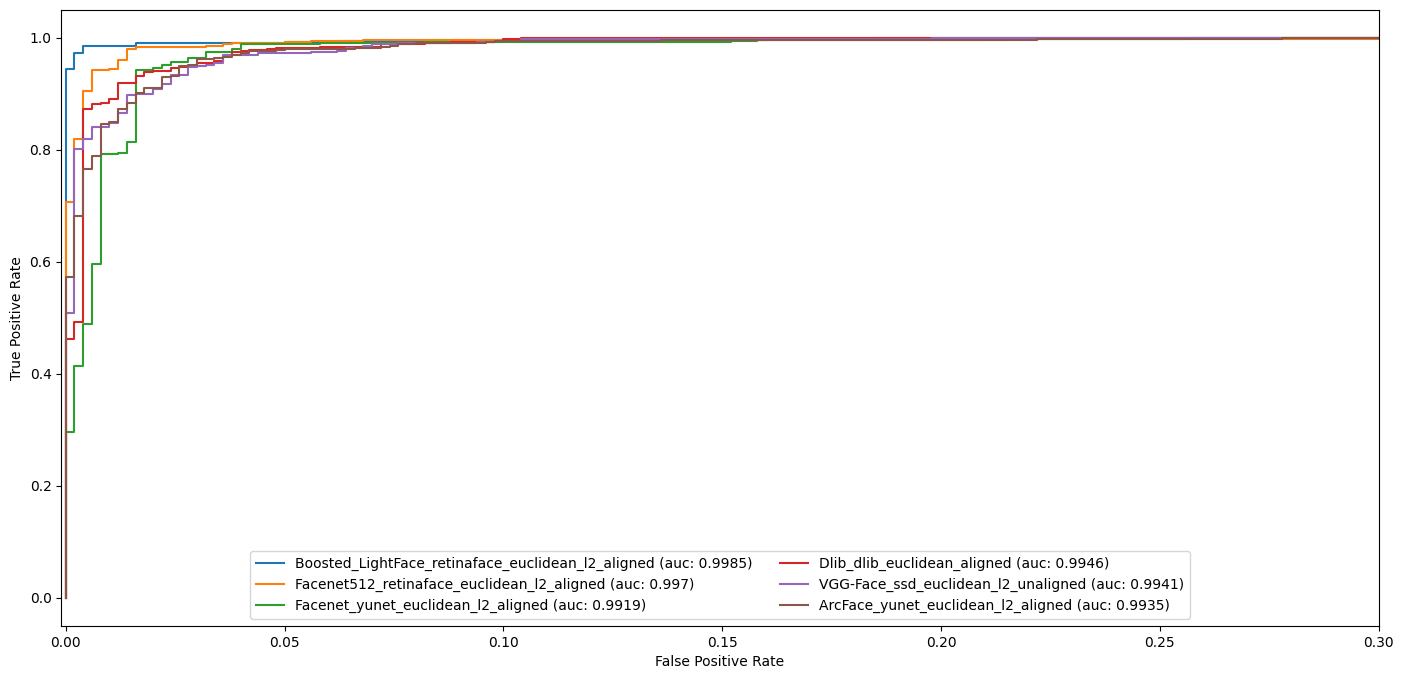

In [45]:
plt.figure(figsize=(17, 8))

# -------------------------------------------
# Boosted LightFace's ROC Curve

plt.plot(
    test_fprs[winner_id],
    test_tprs[winner_id],
    label=f"Boosted_LightFace_retinaface_euclidean_l2_aligned (auc: {test_aucs[winner_id]})"
)

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower center", ncol=2)
# normally this should be [0, 1] but that scale makes graphs not legible

# -------------------------------------------
# Single Model's ROC Curves

# these are the best single model configurations
# according to the https://github.com/serengil/deepface/tree/master/benchmarks (2024-05-09)
single_models = [
    "Facenet512|retinaface|euclidean_l2|aligned",
    "Facenet|yunet|euclidean_l2|aligned",
    "Dlib|dlib|euclidean|aligned",
    "VGG-Face|ssd|euclidean_l2|unaligned",
    "ArcFace|yunet|euclidean_l2|aligned",
]

for single_models in single_models:
    model_name, detector_backend, distance_metric, alignment = single_models.split("|")

    # confirm that distance csv's ready
    calculate_distances(model_name, detector_backend, distance_metric, align = (alignment == "aligned"))

    fpr, tpr, label = plot_roc(model_name, detector_backend, distance_metric, alignment == "aligned")
    plt.plot(fpr, tpr, label=label)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower center", ncol=2)
    
plt.xlim([-0.001, 0.3])
# plt.xlim([-0.001, 0.05])
plt.show()

# Misclassifications

1-th misclassification - false negative (predicted as different persons but actually same person)
actual=1, pred_class=0


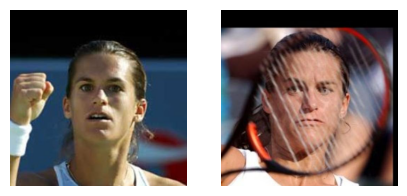

2-th misclassification - false negative (predicted as different persons but actually same person)
actual=1, pred_class=0


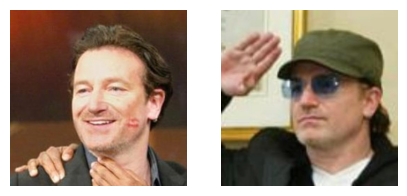

3-th misclassification - false negative (predicted as different persons but actually same person)
actual=1, pred_class=0


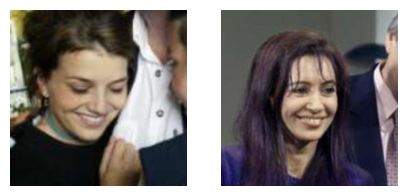

4-th misclassification - false negative (predicted as different persons but actually same person)
actual=1, pred_class=0


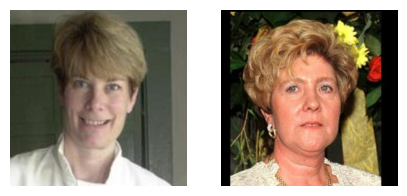

5-th misclassification - false negative (predicted as different persons but actually same person)
actual=1, pred_class=0


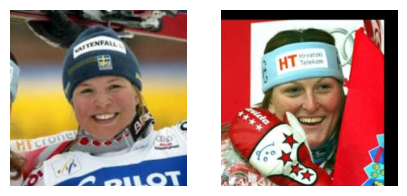

6-th misclassification - false negative (predicted as different persons but actually same person)
actual=1, pred_class=0


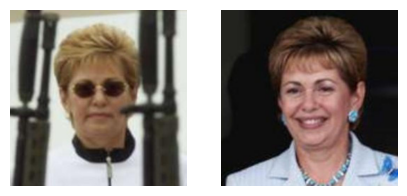

7-th misclassification - false negative (predicted as different persons but actually same person)
actual=1, pred_class=0


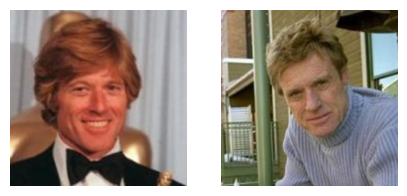

8-th misclassification - false positive (predicted as same person but actually different persons)
actual=0, pred_class=1


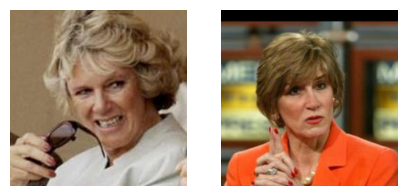

9-th misclassification - false positive (predicted as same person but actually different persons)
actual=0, pred_class=1


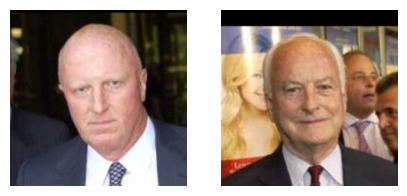

In [46]:
misclf_idx = 0
for i, pred_class in enumerate(pred_classes):
    actual = y_test[i]
    if actual != pred_class:
        misclf_idx += 1
        label = (
            "false negative (predicted as different persons but actually same person)" 
            if (actual == 1 and pred_class == 0) 
            else "false positive (predicted as same person but actually different persons)"
        )
        print(f"{misclf_idx}-th misclassification - {label}")
        print(f"{actual=}, {pred_class=}")

        img1_target = f"lfwe/test/{i}_1.jpg"
        img2_target = f"lfwe/test/{i}_2.jpg"

        img1 = cv2.imread(img1_target)[:,:,::-1]
        img2 = cv2.imread(img2_target)[:,:,::-1]

        # img1 = DeepFace.extract_faces(img_path=img1_target, detector_backend="retinaface")[0]["face"]
        # img2 = DeepFace.extract_faces(img_path=img2_target, detector_backend="retinaface")[0]["face"]
        # img1 = preprocessing.resize_image(img=img1, target_size=(224, 224))[0]
        # img2 = preprocessing.resize_image(img=img2, target_size=(224, 224))[0]

        fig = plt.figure(figsize=(5, 5))

        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        plt.axis("off")

        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        plt.axis("off")

        plt.show()